In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [286]:
from qiskit import IBMQ, execute
import qiskit.tools.jupyter
from qiskit import pulse
from qiskit.pulse import pulse_lib
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

In [3]:
IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
provider = IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
cmd_def = pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])
config = backend.configuration()

In [5]:
anh_almaden = [-320.2, -319.7, -317.2, -320.6, -322.0, -322.5,
               -269.1, -297.1, -320.4, -325.0, -318.7, -319.5,
               -321.1, -319.8, -322.7, -325.5, -320.9, -321.3,
               -321.6, -323.0]

In [6]:
anh = anh_almaden

### Note:
Forgive the quality of this notebook.   I prioritize getting the measurements done over making the notebook pretty.

In [7]:
backend

<IBMQBackend('alt_almaden') from IBMQ(hub='ibm-q-dev', group='qiskit-terra', project='pulse-testing')>

------------

# Qubit Spec Peaks

In [123]:
one_photon_spec_data = pd.read_csv('one_photon_f01_spec.csv')
amps = []
freqs = []
for i in range(len(one_photon_spec_data.amplitude)):
    amps.append(one_photon_spec_data.amplitude[i])
    freqs.append(one_photon_spec_data.drive_freqs[i])

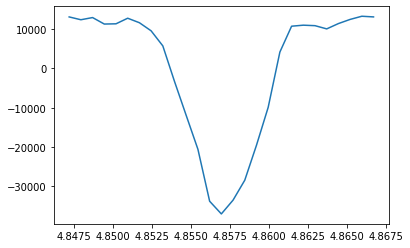

In [124]:
plt.plot(freqs,amps)

In [125]:
one_photon_spec_data = pd.read_csv('two_photon_f02_spec.csv')
amps2 = []
freqs2 = []
for i in range(len(one_photon_spec_data.amplitude)):
    amps2.append(one_photon_spec_data.amplitude[i])
    freqs2.append(one_photon_spec_data.drive_freqs[i])

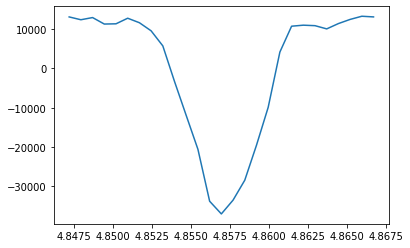

In [128]:
plt.plot(freqs,amps)

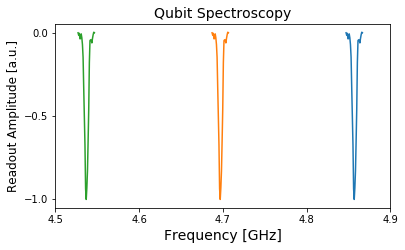

In [403]:
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.gcf().subplots_adjust(bottom=0.15)
plt.plot(freqs,(amps-amps[0])/50000.0)
plt.plot(freqs2,(amps2-amps2[0])/50000.0)
freqs3 = []
for jj,pt in enumerate(freqs):
    freqs3.append(pt-0.3202)
plt.plot(freqs3,(amps2-amps2[0])/50000.0)



plt.ylabel('Readout Amplitude [a.u.]',fontsize=12)
plt.xlabel('Frequency [GHz]',fontsize=14)
plt.title('Qubit Spectroscopy', fontsize=14)
plt.xticks([4.5,4.6,4.7,4.8,4.9])
plt.yticks([-1.0,-0.5,0.0])
plt.savefig('Figures/Qubit_Spec.png', dpi=600)
# plt.savefig('Figures/Qubit_Spec.svg')

# Initial Sanity Check: Confirming Calibrated $\pi$ Pulses

In [81]:
print (DURATION)
print (AMP)


160
0.109


In [109]:
MEASUREMENT_START_TIMESTEP = 500
#Measure only
schedule_measure = pulse.Schedule()
schedule_measure |= measure << MEASUREMENT_START_TIMESTEP


#Pi pulse to 1 state
schedule_pi = pulse.Schedule()
schedule_pi |= cmd_def.get('x', qubits=[0]) << schedule_pi.duration
schedule_pi |= measure << MEASUREMENT_START_TIMESTEP

# pi to 1 then pi to 2
schedule_double_pi = pulse.Schedule()
schedule_double_pi |= cmd_def.get('x', qubits=[0]) << schedule_double_pi.duration
freq = config.dt * anh[0] * 1e6 * -1 # anharmonicity is 312 MHz. In units of dt, we have .304/ns * config.dt/ns
wave_samples_1 = pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=freq).samples - 1j * pulse.pulse_lib.sin(
            duration=DURATION, amp=1, freq=freq).samples
gaussian_samples_1 = pulse.pulse_lib.gaussian(duration=DURATION, amp=0.109/np.sqrt(2), sigma=SIGMA).samples
schedule_double_pi |= pulse.SamplePulse(gaussian_samples_1 * wave_samples_1)(config.drive(0)) << schedule_double_pi.duration
schedule_double_pi |= measure << MEASUREMENT_START_TIMESTEP

#two photon pi to 2
schedule_two_photon = pulse.Schedule()
freq = config.dt * anh[0]*0.5 * 1e6 * -1 # anharmonicity is 312 MHz. In units of dt, we have .304/ns * config.dt/ns
wave_samples = pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=freq).samples - 1j * pulse.pulse_lib.sin(
            duration=DURATION, amp=1, freq=freq).samples
# use amplitude of AMP / sqrt(2) for 1->2 transition
gaussian_samples = pulse.pulse_lib.gaussian(duration=DURATION, amp=0.46245, sigma=SIGMA).samples
schedule_two_photon |= pulse.SamplePulse(gaussian_samples * wave_samples)(config.drive(0)) << schedule_two_photon.duration
schedule_two_photon |= measure << MEASUREMENT_START_TIMESTEP

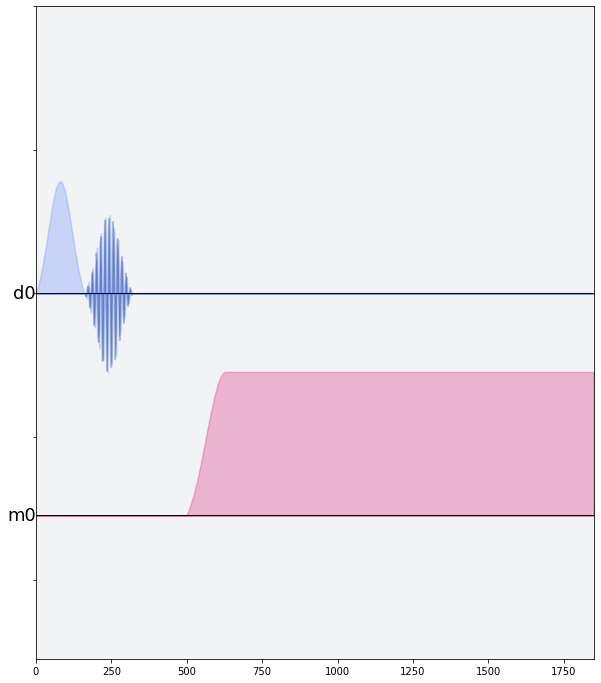

In [110]:
# schedule_measure.draw(plot_range=[0, 1850],channels_to_plot=[config.drive(0),config.measure(0)])
# schedule_pi.draw(plot_range=[0, 1850],channels_to_plot=[config.drive(0),config.measure(0)])
schedule_double_pi.draw(plot_range=[0, 1850],channels_to_plot=[config.drive(0),config.measure(0)])
# schedule_two_photon.draw(plot_range=[0, 1850],channels_to_plot=[config.drive(0),config.measure(0)])

In [111]:
sanity_check_job = execute([schedule_measure, schedule_pi, schedule_double_pi,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')

In [112]:
sanity_check_job.job_id()

'5ddb0665fa67c10018cebf69'

In [392]:
# These are some of the initial plots I made without calibrating the pulses very much but which worked well enough
sanity = backend.retrieve_job('5dd6cb16f5613200186ace9a')
sanity_result = sanity.result(timeout=3600)

In [149]:
sanity = backend.retrieve_job('5ddb0665fa67c10018cebf69')
sanity_result = sanity.result(timeout=3600)

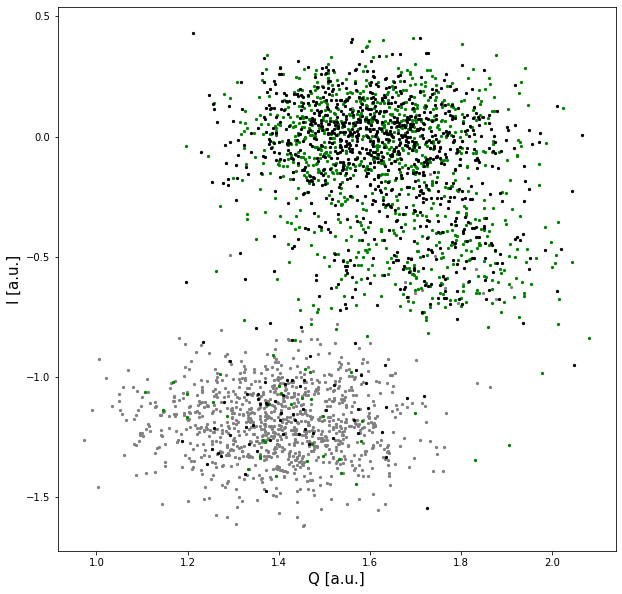

In [394]:
ground = [shot[0] for shot in sanity_result.get_memory(0)]
excited = [shot[0] for shot in sanity_result.get_memory(1)]
f_state = [shot[0] for shot in sanity_result.get_memory(2)]
f_state2  = [shot[0] for shot in sanity_result.get_memory(3)]


plt.figure(figsize=(10,10))
plt.scatter(np.real(ground)/1e15, np.imag(ground)/1e15,s=5, cmap='viridis', c='grey',alpha=1.0, label='state_0_mean')

# plt.scatter(np.real(excited)/1e15, np.imag(excited)/1e15,s=5, cmap='viridis', c='blue',alpha=1.0, label='state_1_mean')

plt.scatter(np.real(f_state)/1e15, np.imag(f_state)/1e15,s=5, cmap='viridis', c='green',alpha=1.0, label='state_2_mean')

plt.scatter(np.real(f_state2)/1e15, np.imag(f_state2)/1e15,s=5, cmap='viridis', c='black',alpha=1.0, label='state_2_mean')


plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)

# plt.legend(["|0>","|1>","|2>", "|2> w 2p"],fontsize=15)
plt.show()

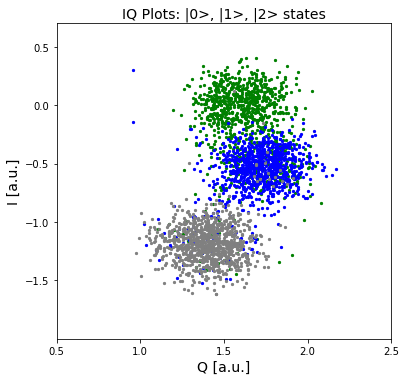

In [395]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.gcf().subplots_adjust(bottom=0.15)
plt.ylabel('I [a.u.]',fontsize=14)
plt.xlabel('Q [a.u.]',fontsize=14)
plt.title('IQ Plots: |0>, |1>, |2> states', fontsize=14)

plt.scatter(np.real(f_state)/1e15, np.imag(f_state)/1e15,s=5, cmap='viridis', c='green',alpha=1.0, label='state_2_mean')

plt.scatter(np.real(excited)/1e15, np.imag(excited)/1e15,s=5, cmap='viridis', c='blue',alpha=1.0, label='state_1_mean')

plt.scatter(np.real(ground)/1e15, np.imag(ground)/1e15,s=5, cmap='viridis', c='grey',alpha=1.0, label='state_0_mean')

plt.xticks(np.arange(0,2.6,0.5))
plt.yticks(np.arange(-1.50,0.6,0.5))
plt.xlim(0.5,2.5)
plt.ylim(-2.0,0.7)

# plt.plot(np.linspace(0, 180, 100), [np.sin(angle * np.pi /180 / 2) ** 2 for angle in np.linspace(0, 180, 100)],
#          label='Expected', color='black')
# ax.legend()
# _ = plt.axis([0, 180, 0, 1])
plt.savefig('Figures/IQ_Plots.png', dpi=600)
# plt.savefig('Figures/IQ_Plots.svg')

In [155]:
schedules = []
MEASUREMENT_START_TIMESTEP = 500
#Measure only
schedule_measure = pulse.Schedule()
schedule_measure |= measure << MEASUREMENT_START_TIMESTEP
schedules.append(schedule_measure)

#Pi pulse to 1 state
schedule_pi = pulse.Schedule()
schedule_pi |= cmd_def.get('x', qubits=[0]) << schedule_pi.duration
schedule_pi |= measure << MEASUREMENT_START_TIMESTEP
schedules.append(schedule_pi)

factors = np.linspace(0.5,2.0)
for jj in range(len(factors)):
    schedule_double_pi = pulse.Schedule()
    schedule_double_pi |= cmd_def.get('x', qubits=[0]) << schedule_double_pi.duration
    freq = config.dt * anh[0] * 1e6 * -1 # anharmonicity is 312 MHz. In units of dt, we have .304/ns * config.dt/ns
    wave_samples_1 = pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=freq).samples - 1j * pulse.pulse_lib.sin(
                duration=DURATION, amp=1, freq=freq).samples
    gaussian_samples_1 = pulse.pulse_lib.gaussian(duration=DURATION, amp=factors[jj]*0.109/np.sqrt(2), sigma=SIGMA).samples
    schedule_double_pi |= pulse.SamplePulse(gaussian_samples_1 * wave_samples_1)(config.drive(0)) << schedule_double_pi.duration
    schedule_double_pi |= measure << MEASUREMENT_START_TIMESTEP
    schedules.append(schedule_double_pi)



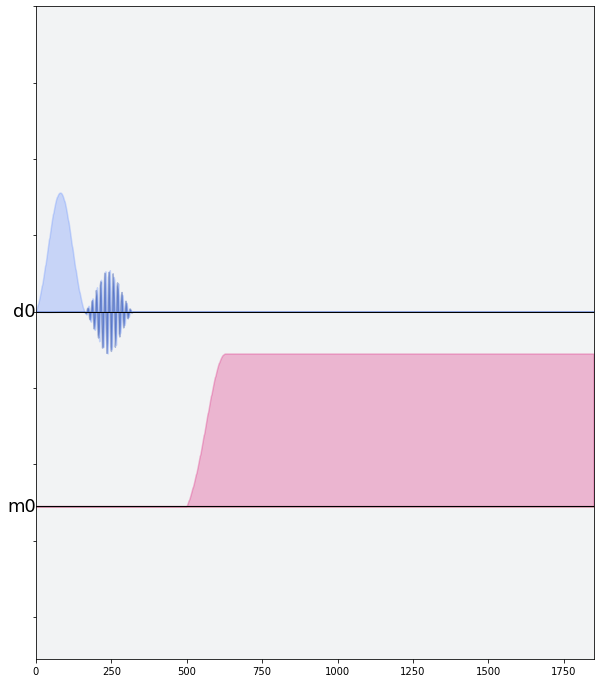

In [158]:
sched = schedules[2]
sched.draw(plot_range=[0, 1850],channels_to_plot=[config.drive(0),config.measure(0)])

In [159]:
cal_12_job = execute(schedules, backend=backend, shots=1000, meas_level=1, meas_return='single')

In [160]:
cal_12_job.job_id()

'5ddb0cb78aa7e00018b8fe59'

In [178]:
cal = backend.retrieve_job('5ddb0cb78aa7e00018b8fe59')
cal_result = cal.result(timeout=3600)

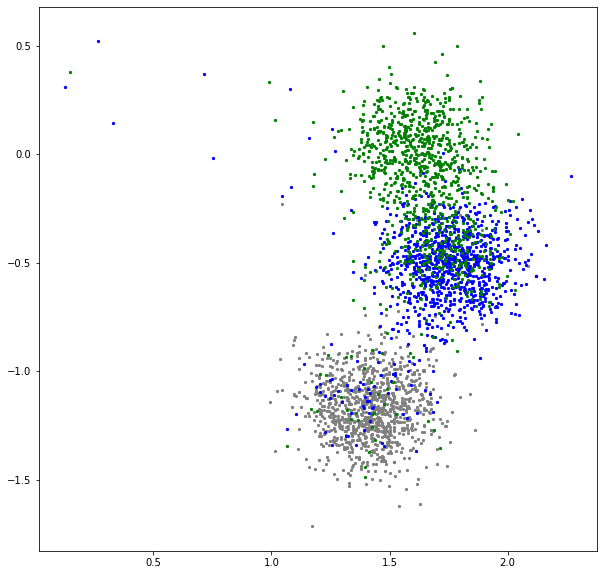

In [248]:
plt.figure(figsize=(10,10))
ground = [shot[0] for shot in cal_result.get_memory(0)]
excited = [shot[0] for shot in cal_result.get_memory(1)]
f_state = [shot[0] for shot in cal_result.get_memory(30)]
f_state2 = [shot[0] for shot in cal_result.get_memory(30)]
plt.scatter(np.real(ground)/1e15, np.imag(ground)/1e15,s=5, cmap='viridis', c='grey',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(excited)/1e15, np.imag(excited)/1e15,s=5, cmap='viridis', c='blue',alpha=1.0, label='state_1_mean')
plt.scatter(np.real(f_state)/1e15, np.imag(f_state)/1e15,s=5, cmap='viridis', c='green',alpha=1.0, label='state_2_mean')
# plt.scatter(np.real(f_state2)/1e15-1.5, np.imag(f_state2)/1e15,s=5, cmap='viridis', c='black',alpha=1.0, label='state_2_mean')


In [253]:
(np.linspace(0.5,2.0)[30])*(0.109/np.sqrt(2))

0.10932015144650388

# Cycling Tests

In [260]:
# pi to 1 then pi to 2
cycle_num =1
MEASUREMENT_START_TIMESTEP = 15000
schedule_cycle = pulse.Schedule()
for i in range(cycle_num):

    schedule_cycle |= cmd_def.get('x', qubits=[0]) << schedule_cycle.duration
    freq = config.dt * anh[0] * 1e6 * -1 # anharmonicity is 312 MHz. In units of dt, we have .304/ns * config.dt/ns
    wave_samples_1 = pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=freq).samples - 1j * pulse.pulse_lib.sin(
                duration=DURATION, amp=1, freq=freq).samples
    gaussian_samples_1 = pulse.pulse_lib.gaussian(duration=DURATION, amp=0.10932, sigma=SIGMA).samples
    schedule_cycle |= pulse.SamplePulse(gaussian_samples_1 * wave_samples_1)(config.drive(0)) << schedule_cycle.duration

    freq = config.dt * anh[0]*0.5 * 1e6 * -1 # anharmonicity is 312 MHz. In units of dt, we have .304/ns * config.dt/ns
    wave_samples = pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=freq).samples - 1j * pulse.pulse_lib.sin(
                duration=DURATION, amp=1, freq=freq).samples
    # use amplitude of AMP / sqrt(2) for 1->2 transition
    gaussian_samples = pulse.pulse_lib.gaussian(duration=DURATION, amp=0.46245, sigma=SIGMA).samples
    schedule_cycle |= pulse.SamplePulse(gaussian_samples * wave_samples)(config.drive(0)) << schedule_cycle.duration

    
# schedule_cycle |= cmd_def.get('x', qubits=[0]) << schedule_cycle.duration
schedule_cycle |= measure << MEASUREMENT_START_TIMESTEP



# Measure only to remove IQ oscillations
schedule_measure = pulse.Schedule()
schedule_measure |= measure << MEASUREMENT_START_TIMESTEP
# 01 Pi pulse to remove IQ oscillations
schedule_pi = pulse.Schedule()
schedule_pi |= cmd_def.get('x', qubits=[0]) << schedule_pi.duration
schedule_pi |= measure << MEASUREMENT_START_TIMESTEP
# 02 Pi pilse to remove IQ oscillations
schedule_two_photon = pulse.Schedule()
freq = config.dt * anh[0]*0.5 * 1e6 * -1 # anharmonicity is 312 MHz. In units of dt, we have .304/ns * config.dt/ns
wave_samples = pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=freq).samples - 1j * pulse.pulse_lib.sin(
            duration=DURATION, amp=1, freq=freq).samples
# use amplitude of AMP / sqrt(2) for 1->2 transition
gaussian_samples = pulse.pulse_lib.gaussian(duration=DURATION, amp=6.0*AMP / np.sqrt(2), sigma=SIGMA).samples
schedule_two_photon |= pulse.SamplePulse(gaussian_samples * wave_samples)(config.drive(0)) << schedule_two_photon.duration
schedule_two_photon |= measure << MEASUREMENT_START_TIMESTEP

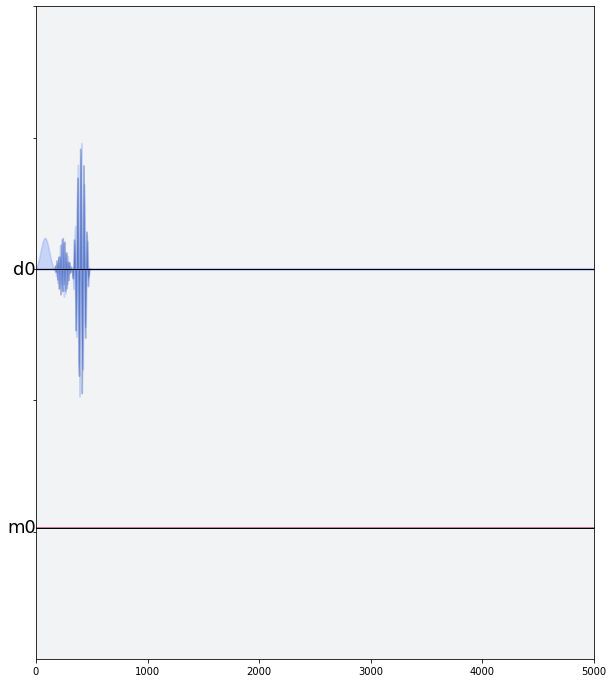

In [261]:
schedule_cycle.draw(plot_range=[0, 5000],channels_to_plot=[config.drive(0),config.measure(0)])

In [262]:
single_cycle_job = execute([schedule_measure, schedule_pi,schedule_cycle,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')


In [276]:
single_cycle_job.job_id()

'5ddb150a7b80db001831683f'

In [288]:
single_cycle = backend.retrieve_job('5ddb150a7b80db001831683f')
single_cycle_result = single_cycle.result(timeout=3600)

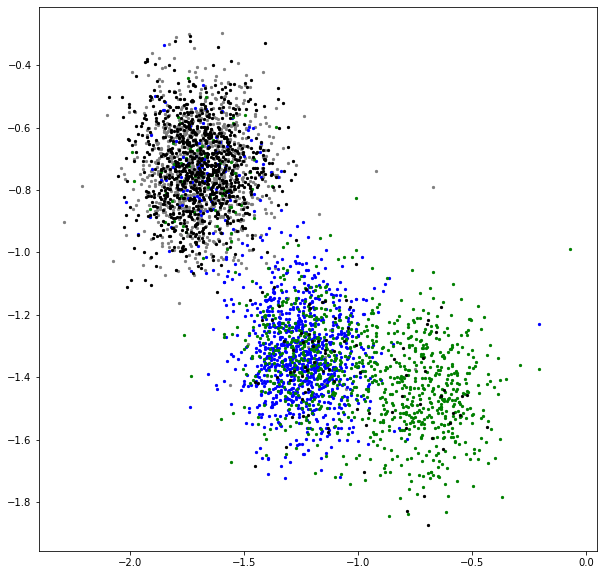

In [289]:
plt.figure(figsize=(10,10))
ground = [shot[0] for shot in single_cycle_result.get_memory(0)]
excited = [shot[0] for shot in single_cycle_result.get_memory(1)]
ground_cycle = [shot[0] for shot in single_cycle_result.get_memory(2)]
f_state = [shot[0] for shot in single_cycle_result.get_memory(3)]
plt.scatter(np.real(ground)/1e15, np.imag(ground)/1e15,s=5, cmap='viridis', c='grey',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(excited)/1e15, np.imag(excited)/1e15,s=5, cmap='viridis', c='blue',alpha=1.0, label='state_1_mean')
plt.scatter(np.real(f_state)/1e15, np.imag(f_state)/1e15,s=5, cmap='viridis', c='green',alpha=1.0, label='state_2_mean')
plt.scatter(np.real(ground_cycle)/1e15, np.imag(ground_cycle)/1e15,s=5, cmap='viridis', c='black',alpha=1.0, label='state_2_mean')


# Multiple Cycle Jobs

In [263]:
def cycle_job(cycle_num):
    MEASUREMENT_START_TIMESTEP = 15000
    schedule_cycle2 = pulse.Schedule()
    for i in range(cycle_num):

        schedule_cycle2 |= cmd_def.get('x', qubits=[0]) << schedule_cycle2.duration
        freq = config.dt * anh[0] * 1e6 * -1 # anharmonicity is 312 MHz. In units of dt, we have .304/ns * config.dt/ns
        wave_samples_1 = pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=freq).samples - 1j * pulse.pulse_lib.sin(
                    duration=DURATION, amp=1, freq=freq).samples
        gaussian_samples_1 = pulse.pulse_lib.gaussian(duration=DURATION, amp=0.10932, sigma=SIGMA).samples
        schedule_cycle2 |= pulse.SamplePulse(gaussian_samples_1 * wave_samples_1)(config.drive(0)) << schedule_cycle2.duration

        freq = config.dt * anh[0]*0.5 * 1e6 * -1 # anharmonicity is 312 MHz. In units of dt, we have .304/ns * config.dt/ns
        wave_samples = pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=freq).samples - 1j * pulse.pulse_lib.sin(
                    duration=DURATION, amp=1, freq=freq).samples
        # use amplitude of AMP / sqrt(2) for 1->2 transition
        gaussian_samples = pulse.pulse_lib.gaussian(duration=DURATION, amp=0.46245, sigma=SIGMA).samples
        schedule_cycle2 |= pulse.SamplePulse(gaussian_samples * wave_samples)(config.drive(0)) << schedule_cycle2.duration


    # schedule_cycle |= cmd_def.get('x', qubits=[0]) << schedule_cycle.duration
    schedule_cycle2 |= measure << MEASUREMENT_START_TIMESTEP
    return schedule_cycle2

In [271]:
two_cycle_job = cycle_job(2)
three_cycle_job = cycle_job(3)
four_cycle_job = cycle_job(4)
five_cycle_job = cycle_job(5)
six_cycle_job = cycle_job(6)
seven_cycle_job = cycle_job(7)
eight_cycle_job = cycle_job(8)
nine_cycle_job = cycle_job(9)
ten_cycle_job = cycle_job(10)

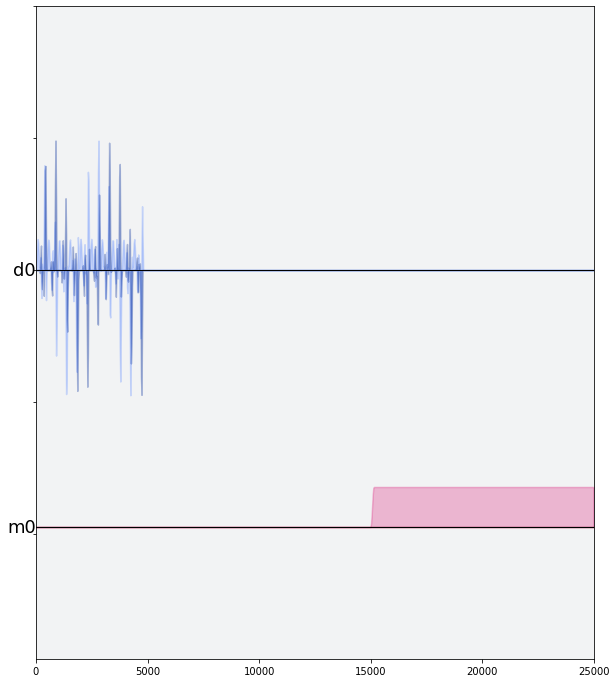

In [386]:
ten_cycle_job.draw(plot_range=[0, 25000],channels_to_plot=[config.drive(0),config.measure(0)])

In [273]:
multi_cycle_jobs = execute([two_cycle_job,three_cycle_job,four_cycle_job,five_cycle_job,ten_cycle_job], backend=backend, shots=1000, meas_level=1, meas_return='single')


In [274]:
multi_cycle_jobs.job_id()

'5ddb169ffa67c10018cebf81'

In [281]:
multi_cycle = backend.retrieve_job('5ddb169ffa67c10018cebf81')
multi_cycle_result = multi_cycle.result(timeout=3600)

In [322]:
plt.figure(figsize=(10,10))
two_cycles = [shot[0] for shot in multi_cycle_result.get_memory(0)]
three_cycles = [shot[0] for shot in multi_cycle_result.get_memory(1)]
four_cycles = [shot[0] for shot in multi_cycle_result.get_memory(2)]
five_cycles = [shot[0] for shot in multi_cycle_result.get_memory(3)]
ten_cycles = [shot[0] for shot in multi_cycle_result.get_memory(4)]

<Figure size 720x720 with 0 Axes>

In [329]:
# one_cycle_ratio = cycle_drop_ratio(two_cycles,reveal_val=False,plot=False)
two_cycle_ratio = cycle_drop_ratio(two_cycles,reveal_val=False,plot=False)
three_cycle_ratio = cycle_drop_ratio(three_cycles,reveal_val=False,plot=False)
four_cycle_ratio = cycle_drop_ratio(four_cycles,reveal_val=False,plot=False)
five_cycle_ratio = cycle_drop_ratio(five_cycles,reveal_val=False,plot=False)
ten_cycle_ratio = cycle_drop_ratio(ten_cycles,reveal_val=False,plot=False)

In [331]:
print (two_cycle_ratio,three_cycle_ratio,four_cycle_ratio,five_cycle_ratio,ten_cycle_ratio)

0.823 0.897 0.935 0.914 0.817


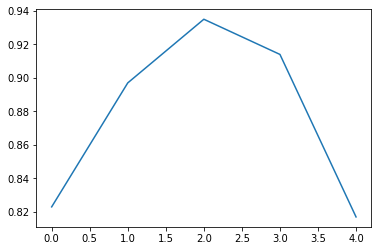

In [332]:
plt.plot([two_cycle_ratio,three_cycle_ratio,four_cycle_ratio,five_cycle_ratio,ten_cycle_ratio])

In [333]:
multi_cycle_jobs2 = execute([six_cycle_job,seven_cycle_job,eight_cycle_job,nine_cycle_job,ten_cycle_job], backend=backend, shots=1000, meas_level=1, meas_return='single')



In [335]:
multi_cycle_jobs2.job_id()

'5ddb23362efcfc00184ebb34'

In [362]:
multi_cycle = backend.retrieve_job('5ddb23362efcfc00184ebb34')
multi_cycle_result = multi_cycle.result(timeout=3600)
six_cycles = [shot[0] for shot in multi_cycle_result.get_memory(0)]
seven_cycles = [shot[0] for shot in multi_cycle_result.get_memory(1)]
eight_cycles = [shot[0] for shot in multi_cycle_result.get_memory(2)]
nine_cycles = [shot[0] for shot in multi_cycle_result.get_memory(3)]
ten_cycles = [shot[0] for shot in multi_cycle_result.get_memory(4)]

<Figure size 720x720 with 0 Axes>

In [363]:
# one_cycle_ratio = cycle_drop_ratio(two_cycles,reveal_val=False,plot=False)
six_cycle_ratio = cycle_drop_ratio(six_cycles,reveal_val=False,plot=False)
seven_cycle_ratio = cycle_drop_ratio(seven_cycles,reveal_val=False,plot=False)
eight_cycle_ratio = cycle_drop_ratio(eight_cycles,reveal_val=False,plot=False)
nine_cycle_ratio = cycle_drop_ratio(nine_cycles,reveal_val=False,plot=False)
ten_cycle_ratio = cycle_drop_ratio(ten_cycles,reveal_val=False,plot=False)

In [336]:
cycle11_job = cycle_job(11)
cycle12_job = cycle_job(12)
cycle13_job = cycle_job(13)
cycle14_job = cycle_job(14)
cycle15_job = cycle_job(15)
cycle16_job = cycle_job(16)
cycle17_job = cycle_job(17)
cycle18_job = cycle_job(18)
cycle19_job = cycle_job(19)
cycle20_job = cycle_job(20)
cycle21_job = cycle_job(21)
cycle22_job = cycle_job(22)

In [337]:
multi_cycle_jobs3 = execute([cycle11_job,cycle12_job,cycle13_job,cycle14_job,cycle15_job,cycle16_job,cycle17_job,cycle18_job,cycle19_job,cycle20_job,cycle21_job,cycle22_job], backend=backend, shots=1000, meas_level=1, meas_return='single')



In [338]:
multi_cycle_jobs3.job_id()

'5ddb23e5af2f73001805e27a'

In [342]:
multi_cycle3 = backend.retrieve_job('5ddb23e5af2f73001805e27a')
multi_cycle3_result = multi_cycle3.result(timeout=3600)

In [343]:

cycles11 = [shot[0] for shot in multi_cycle3_result.get_memory(0)]
cycles12 = [shot[0] for shot in multi_cycle3_result.get_memory(1)]
cycles13 = [shot[0] for shot in multi_cycle3_result.get_memory(2)]
cycles14 = [shot[0] for shot in multi_cycle3_result.get_memory(3)]
cycles15 = [shot[0] for shot in multi_cycle3_result.get_memory(4)]
cycles16 = [shot[0] for shot in multi_cycle3_result.get_memory(5)]
cycles17 = [shot[0] for shot in multi_cycle3_result.get_memory(6)]
cycles18 = [shot[0] for shot in multi_cycle3_result.get_memory(7)]
cycles19 = [shot[0] for shot in multi_cycle3_result.get_memory(8)]
cycles20 = [shot[0] for shot in multi_cycle3_result.get_memory(9)]
cycles21 = [shot[0] for shot in multi_cycle3_result.get_memory(10)]
cycles22 = [shot[0] for shot in multi_cycle3_result.get_memory(11)]


In [344]:
# one_cycle_ratio = cycle_drop_ratio(two_cycles,reveal_val=False,plot=False)
cycle11_ratio = cycle_drop_ratio(cycles11,reveal_val=False,plot=False)
cycle12_ratio = cycle_drop_ratio(cycles12,reveal_val=False,plot=False)
cycle13_ratio = cycle_drop_ratio(cycles13,reveal_val=False,plot=False)
cycle14_ratio = cycle_drop_ratio(cycles14,reveal_val=False,plot=False)
cycle15_ratio = cycle_drop_ratio(cycles15,reveal_val=False,plot=False)
cycle16_ratio = cycle_drop_ratio(cycles16,reveal_val=False,plot=False)
cycle17_ratio = cycle_drop_ratio(cycles17,reveal_val=False,plot=False)
cycle18_ratio = cycle_drop_ratio(cycles18,reveal_val=False,plot=False)
cycle19_ratio = cycle_drop_ratio(cycles19,reveal_val=False,plot=False)
cycle20_ratio = cycle_drop_ratio(cycles20,reveal_val=False,plot=False)
cycle21_ratio = cycle_drop_ratio(cycles21,reveal_val=False,plot=False)
cycle22_ratio = cycle_drop_ratio(cycles22,reveal_val=False,plot=False)



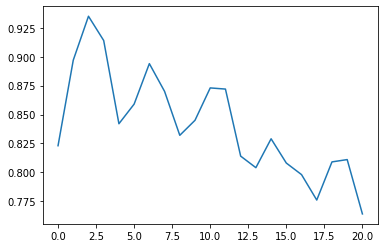

In [367]:

plt.plot([two_cycle_ratio,three_cycle_ratio,four_cycle_ratio,five_cycle_ratio,six_cycle_ratio,seven_cycle_ratio,eight_cycle_ratio,nine_cycle_ratio,ten_cycle_ratio,cycle11_ratio,cycle12_ratio,cycle13_ratio,cycle14_ratio,cycle15_ratio,cycle16_ratio,cycle17_ratio,cycle18_ratio,cycle19_ratio,cycle20_ratio,cycle21_ratio,cycle22_ratio])

In [347]:
cycle23_job = cycle_job(23)
cycle24_job = cycle_job(24)
cycle25_job = cycle_job(25)
cycle26_job = cycle_job(26)
cycle27_job = cycle_job(27)
cycle28_job = cycle_job(28)
cycle29_job = cycle_job(29)
cycle30_job = cycle_job(30)
cycle31_job = cycle_job(31)
cycle32_job = cycle_job(32)
cycle33_job = cycle_job(33)
cycle34_job = cycle_job(34)

In [348]:
multi_cycle_jobs3 = execute([cycle23_job,cycle24_job,cycle25_job,cycle26_job,cycle27_job,cycle28_job,cycle29_job,cycle30_job,cycle31_job,cycle32_job,cycle33_job,cycle34_job], backend=backend, shots=1000, meas_level=1, meas_return='single')
## NOTE: I messed up and did change the job name. should be multi_cycle_jobs4  Dont want to submit two jobs.


In [349]:
multi_cycle_jobs3.job_id()

'5ddb3487d4872d00185a62a3'

In [368]:
multi_cycle4 = backend.retrieve_job('5ddb3487d4872d00185a62a3')
multi_cycle4_result = multi_cycle4.result(timeout=3600)

In [369]:

cycles23 = [shot[0] for shot in multi_cycle4_result.get_memory(0)]
cycles24 = [shot[0] for shot in multi_cycle4_result.get_memory(1)]
cycles25 = [shot[0] for shot in multi_cycle4_result.get_memory(2)]
cycles26 = [shot[0] for shot in multi_cycle4_result.get_memory(3)]
cycles27 = [shot[0] for shot in multi_cycle4_result.get_memory(4)]
cycles28 = [shot[0] for shot in multi_cycle4_result.get_memory(5)]
cycles29 = [shot[0] for shot in multi_cycle4_result.get_memory(6)]
cycles30 = [shot[0] for shot in multi_cycle4_result.get_memory(7)]
cycles31 = [shot[0] for shot in multi_cycle4_result.get_memory(8)]
cycles32 = [shot[0] for shot in multi_cycle4_result.get_memory(9)]
cycles33 = [shot[0] for shot in multi_cycle4_result.get_memory(10)]
cycles34 = [shot[0] for shot in multi_cycle4_result.get_memory(11)]


In [370]:
# one_cycle_ratio = cycle_drop_ratio(two_cycles,reveal_val=False,plot=False)
cycle23_ratio = cycle_drop_ratio(cycles23,reveal_val=False,plot=False)
cycle24_ratio = cycle_drop_ratio(cycles24,reveal_val=False,plot=False)
cycle25_ratio = cycle_drop_ratio(cycles25,reveal_val=False,plot=False)
cycle26_ratio = cycle_drop_ratio(cycles26,reveal_val=False,plot=False)
cycle27_ratio = cycle_drop_ratio(cycles27,reveal_val=False,plot=False)
cycle28_ratio = cycle_drop_ratio(cycles28,reveal_val=False,plot=False)
cycle29_ratio = cycle_drop_ratio(cycles29,reveal_val=False,plot=False)
cycle30_ratio = cycle_drop_ratio(cycles30,reveal_val=False,plot=False)
cycle31_ratio = cycle_drop_ratio(cycles31,reveal_val=False,plot=False)
cycle32_ratio = cycle_drop_ratio(cycles32,reveal_val=False,plot=False)
cycle33_ratio = cycle_drop_ratio(cycles33,reveal_val=False,plot=False)
cycle34_ratio = cycle_drop_ratio(cycles34,reveal_val=False,plot=False)



(0.5, 1.0)

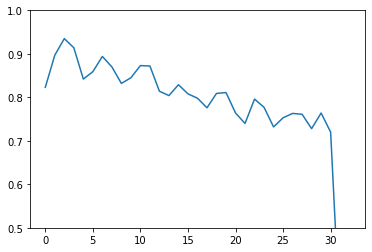

In [375]:

plt.plot([two_cycle_ratio,three_cycle_ratio,four_cycle_ratio,five_cycle_ratio,six_cycle_ratio,seven_cycle_ratio,eight_cycle_ratio,nine_cycle_ratio,ten_cycle_ratio,cycle11_ratio,cycle12_ratio,cycle13_ratio,cycle14_ratio,cycle15_ratio,cycle16_ratio,cycle17_ratio,cycle18_ratio,cycle19_ratio,cycle20_ratio,cycle21_ratio,cycle22_ratio,cycle23_ratio,cycle24_ratio,cycle25_ratio,cycle26_ratio,cycle27_ratio,cycle28_ratio,cycle29_ratio,cycle30_ratio,cycle31_ratio,cycle32_ratio,cycle33_ratio,cycle34_ratio])



plt.ylim(0.5,1.0)


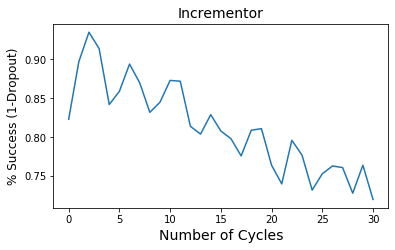

In [390]:
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.gcf().subplots_adjust(bottom=0.15)
plt.plot([two_cycle_ratio,three_cycle_ratio,four_cycle_ratio,five_cycle_ratio,six_cycle_ratio,seven_cycle_ratio,eight_cycle_ratio,nine_cycle_ratio,ten_cycle_ratio,cycle11_ratio,cycle12_ratio,cycle13_ratio,cycle14_ratio,cycle15_ratio,cycle16_ratio,cycle17_ratio,cycle18_ratio,cycle19_ratio,cycle20_ratio,cycle21_ratio,cycle22_ratio,cycle23_ratio,cycle24_ratio,cycle25_ratio,cycle26_ratio,cycle27_ratio,cycle28_ratio,cycle29_ratio,cycle30_ratio,cycle31_ratio,cycle32_ratio])




plt.ylabel('% Success (1-Dropout)',fontsize=12)
plt.xlabel('Number of Cycles',fontsize=14)
plt.title('Incrementor', fontsize=14)
# plt.xticks([4.675,4.75,4.825,4.9])
# plt.yticks([-1.0,-0.5,0.0])
plt.savefig('Figures/Incrementor.png', dpi=600)
# plt.savefig('Figures/Qubit_Spec.svg')


In [350]:
cycle35_job = cycle_job(35)
cycle36_job = cycle_job(36)
cycle37_job = cycle_job(37)
cycle38_job = cycle_job(38)
cycle39_job = cycle_job(39)
cycle40_job = cycle_job(40)
cycle41_job = cycle_job(41)
cycle42_job = cycle_job(42)
cycle43_job = cycle_job(43)
cycle44_job = cycle_job(44)
cycle45_job = cycle_job(45)
cycle46_job = cycle_job(46)

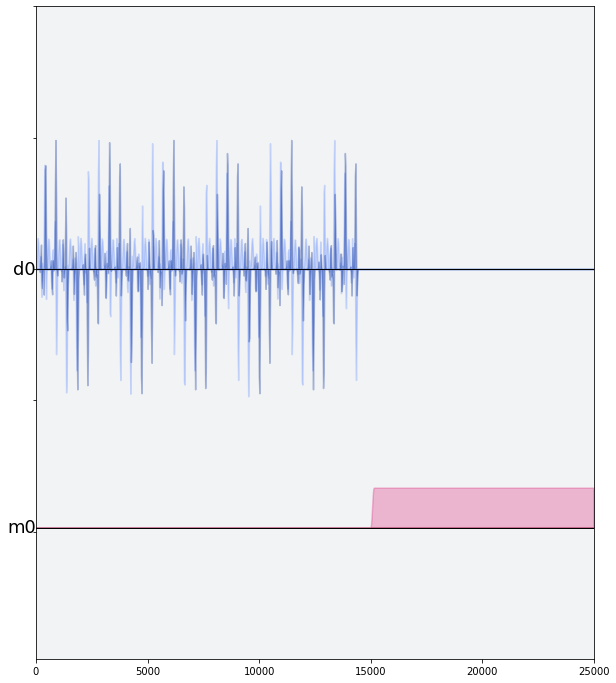

In [374]:
cycle30_job.draw(plot_range=[0, 25000],channels_to_plot=[config.drive(0),config.measure(0)])

In [352]:
multi_cycle_jobs5 = execute([cycle35_job,cycle36_job,cycle37_job,cycle38_job,cycle39_job,cycle40_job,cycle41_job,cycle42_job,cycle43_job,cycle44_job,cycle45_job,cycle46_job], backend=backend, shots=1000, meas_level=1, meas_return='single')



In [353]:
multi_cycle_jobs5.job_id()

'5ddb35af7b80db001831689c'

In [354]:
cycle47_job = cycle_job(47)
cycle48_job = cycle_job(48)
cycle49_job = cycle_job(49)
cycle50_job = cycle_job(50)

In [355]:
multi_cycle_jobs6 = execute([cycle47_job,cycle48_job,cycle49_job,cycle50_job], backend=backend, shots=1000, meas_level=1, meas_return='single')



In [356]:
multi_cycle_jobs6.job_id()

'5ddb3603af2f73001805e291'

# Constructing Dropout Fidelity

In [285]:
# apparently np.c_ also does this (column stack)
def reshape_complex_vec(vec):
    """ Take in complex vector vec and return 2d array w/ real, imag entries
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [293]:
# Get the training Data from the decently calibrated pulses
ground = [shot[0] for shot in single_cycle_result.get_memory(0)]
excited = [shot[0] for shot in single_cycle_result.get_memory(1)]
ground_cycle = [shot[0] for shot in single_cycle_result.get_memory(2)]
f_state = [shot[0] for shot in single_cycle_result.get_memory(3)]

shots=1000
data0_reshaped = reshape_complex_vec(ground)
data1_reshaped = reshape_complex_vec(excited) 
data2_reshaped = reshape_complex_vec(f_state)  

print(data1_reshaped[0])

IQ_data = np.concatenate((data0_reshaped, data1_reshaped, data2_reshaped))
print(IQ_data.shape)

# construct vector w/ 0's, 1's and and 2's correspoding to IQ points
num_shots = shots # ran w/ extra shots
state = np.zeros(num_shots) # num_shots gives number of experiments
state = np.concatenate((state, np.ones(num_shots)))
state = np.concatenate((state, 2*np.ones(num_shots)))
print(len(state))
print (state[2500])

# Shuffle and split data in training and test sets (evently->0.5 parameter)
IQ_train, IQ_test, state_train, state_test = train_test_split(IQ_data, state, test_size=0.5)

[-1.58142065e+15 -1.02075072e+15]
(3000, 2)
3000
2.0


In [291]:
# Set up the LDA
LDA = LinearDiscriminantAnalysis()
LDA.fit(IQ_train, state_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [292]:
print(LDA.predict([[-1.75e15,-0.72e15], [-1.25e15,-1.3e15], [-0.75e15,-1.4e15]]))




[0. 1. 2.]


In [295]:
ground_drop_out = []
for i in range(len(data0_reshaped)):
    x = LDA.predict([[data0_reshaped[i][0],data0_reshaped[i][1]]])
    ground_drop_out.append(x[0])
excited_drop_out = []
for i in range(len(data1_reshaped)):
    x = LDA.predict([[data1_reshaped[i][0],data1_reshaped[i][1]]])
    excited_drop_out.append(x[0])
f_drop_out = []
for i in range(len(data2_reshaped)):
    x = LDA.predict([[data2_reshaped[i][0],data2_reshaped[i][1]]])
    f_drop_out.append(x[0])

# cycle_drop_out = []
# for i in range(len(cycle_reshaped)):
#     x = LDA.predict([[cycle_reshaped[i][0],cycle_reshaped[i][1]]])
#     cycle_drop_out.append(x[0])


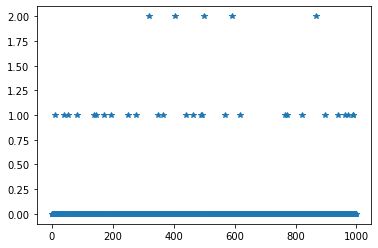

In [298]:
plt.plot(ground_drop_out,"*")

0.968


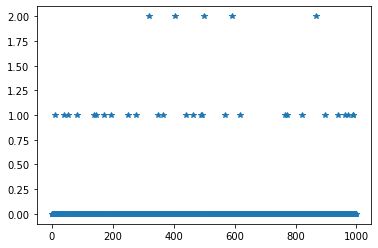

In [299]:
plt.plot(ground_drop_out,"*")
ground_drop_out_ratio = []
for ii,pt in enumerate(ground_drop_out):
    if pt==0:
        ground_drop_out_ratio.append(1)
    else:
        ground_drop_out_ratio.append(0)
print (sum(ground_drop_out_ratio)/len(ground_drop_out_ratio))

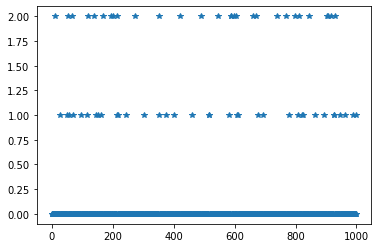

In [306]:
single_cycle_data_reshaped = reshape_complex_vec(ground_cycle)
single_cycle_drop_out = []
for i in range(len(single_cycle_data_reshaped)):
    x = LDA.predict([[single_cycle_data_reshaped[i][0],single_cycle_data_reshaped[i][1]]])
    single_cycle_drop_out.append(x[0])
plt.plot(single_cycle_drop_out,"*")

In [307]:
single_cycle_drop_out_ratio = []
for ii,pt in enumerate(single_cycle_drop_out):
    if pt==0:
        single_cycle_drop_out_ratio.append(1)
    else:
        single_cycle_drop_out_ratio.append(0)
print (sum(single_cycle_drop_out_ratio)/len(single_cycle_drop_out_ratio))

0.935


In [317]:
def cycle_drop_ratio(ground_cycle,plot=False,reveal_val=False):
    single_cycle_data_reshaped = reshape_complex_vec(ground_cycle)
    single_cycle_drop_out = []
    for i in range(len(single_cycle_data_reshaped)):
        x = LDA.predict([[single_cycle_data_reshaped[i][0],single_cycle_data_reshaped[i][1]]])
        single_cycle_drop_out.append(x[0])
    if plot:
        plt.plot(single_cycle_drop_out,"*")

    single_cycle_drop_out_ratio = []
    for ii,pt in enumerate(single_cycle_drop_out):
        if pt==0:
            single_cycle_drop_out_ratio.append(1)
        else:
            single_cycle_drop_out_ratio.append(0)
    if reveal_val:
        print (sum(single_cycle_drop_out_ratio)/len(single_cycle_drop_out_ratio))
    ratio = (sum(single_cycle_drop_out_ratio)/len(single_cycle_drop_out_ratio))
    return ratio

0.935


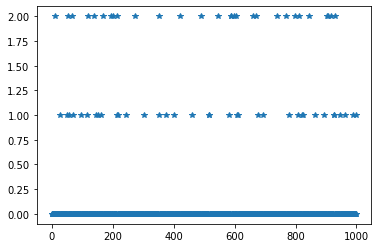

In [321]:
drop_out_ratio =  cycle_drop_ratio(ground_cycle,reveal_val=True,plot=True)

In [319]:
drop_out_ratio

0.935

# Cycle Tests Prior to Calibrated $\pi$ Pulses

In [290]:
cycle20_job = execute([schedule_measure, schedule_pi,schedule_cycle,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')


In [423]:
cycle10_job = execute([schedule_measure, schedule_pi,schedule_cycle,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')


In [426]:
cycle2_job = execute([schedule_measure, schedule_pi,schedule_cycle,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')


In [429]:
cycle3_job = execute([schedule_measure, schedule_pi,schedule_cycle,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')


In [432]:
cycle4_job = execute([schedule_measure, schedule_pi,schedule_cycle,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')


In [435]:
cycle5_job = execute([schedule_measure, schedule_pi,schedule_cycle,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')


In [440]:
cycle6_job = execute([schedule_measure, schedule_pi,schedule_cycle,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')


In [443]:
cycle7_job = execute([schedule_measure, schedule_pi,schedule_cycle,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')


In [445]:
print (cycle2_job.job_id())
print (cycle3_job.job_id())
print (cycle4_job.job_id())
print (cycle5_job.job_id())
print (cycle6_job.job_id())
print (cycle7_job.job_id())

5dd71a34c02fc600186349a5
5dd71a490bf24b0018b732b1
5dd71a65a903af00180afa0c
5dd71a7f0bf24b0018b732b3
5dd71aa20bf24b0018b732b5
5dd71ab7fa67c10018ceb2e6


In [449]:
cycle8_job = execute([schedule_measure, schedule_pi,schedule_cycle,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')


In [450]:
print (cycle8_job.job_id())

5dd71af6f5613200186acfcb


In [455]:
cycle9_job = execute([schedule_measure, schedule_pi,schedule_cycle,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')


In [456]:
print (cycle9_job.job_id())

5dd71b1efa67c10018ceb2e8


In [459]:
cycle11_job = execute([schedule_measure, schedule_pi,schedule_cycle,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')
print (cycle11_job.job_id())

5dd71b45c02fc600186349a8


In [462]:
cycle12_job = execute([schedule_measure, schedule_pi,schedule_cycle,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')
print (cycle12_job.job_id())

5dd71b5bf5613200186acfce


In [468]:
test_readout_job = execute([schedule_measure, schedule_pi,schedule_cycle,schedule_two_photon], backend=backend, shots=1000, meas_level=1, meas_return='single')
print (test_readout_job.job_id())

5dd71c97d4872d00185a5592


In [342]:
cycle20_job.job_id()

'5dd6dee72efcfc00184ead2a'

In [477]:
sanity = backend.retrieve_job('5dd71a65a903af00180afa0c')
sanity_result = sanity.result(timeout=3600)

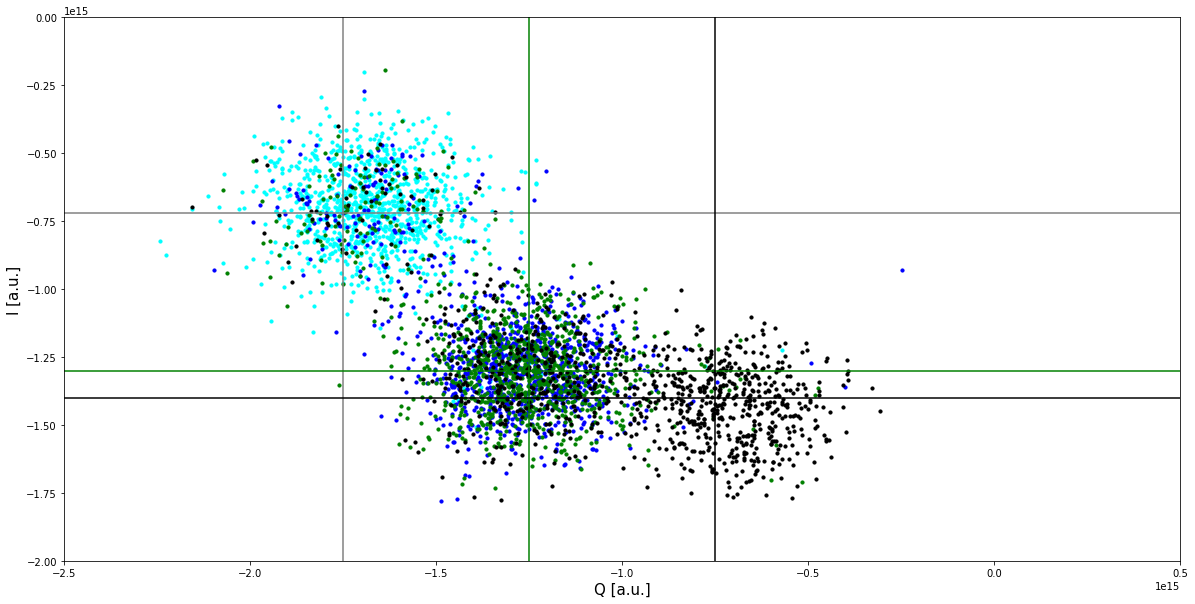

In [479]:
ground = [shot[0] for shot in sanity_result.get_memory(0)]
excited = [shot[0] for shot in sanity_result.get_memory(1)]
e_cycle = [shot[0] for shot in sanity_result.get_memory(2)]
f_state2  = [shot[0] for shot in sanity_result.get_memory(3)]


plt.figure(figsize=(20,10))
plt.scatter(np.real(ground), np.imag(ground), 
            s=10, cmap='viridis', c='cyan',alpha=1.0, label='state_0_mean')

plt.scatter(np.real(excited), np.imag(excited), 
            s=10, cmap='viridis', c='blue',alpha=1.0, label='state_1_mean')

plt.scatter(np.real(e_cycle), np.imag(e_cycle), 
            s=10, cmap='viridis', c='green',alpha=1.0, label='state_2_mean')

plt.scatter(np.real(f_state2), np.imag(f_state2), 
            s=10, cmap='viridis', c='black',alpha=1.0, label='state_2_mean')


plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.xlim(-2.5e15,0.5e15)
plt.ylim(-2e15,0)
#putting lines on the 0
plt.axvline(-1.75e15,color='grey')
plt.axhline(-0.72e15,color='grey')
#putting lines on the 1
plt.axvline(-1.25e15,color='green')
plt.axhline(-1.3e15,color='green')

#putting lines on the 2
plt.axvline(-0.75e15,color='black')
plt.axhline(-1.4e15,color='black')


# plt.legend(["|0>","|1>","|1>c", "|2> w 2p"],fontsize=25)
plt.show()

In [481]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# Create IQ vector
shots=1000
data0_reshaped = reshape_complex_vec(ground)
data1_reshaped = reshape_complex_vec(excited) 
data2_reshaped = reshape_complex_vec(f_state2)  
cycle_reshaped = reshape_complex_vec(e_cycle)

print(data1_reshaped[0])

IQ_data = np.concatenate((data0_reshaped, data1_reshaped, data2_reshaped))
print(IQ_data.shape)

# construct vector w/ 0's, 1's and and 2's correspoding to IQ points
num_shots = shots # ran w/ extra shots
state = np.zeros(num_shots) # num_shots gives number of experiments
state = np.concatenate((state, np.ones(num_shots)))
state = np.concatenate((state, 2*np.ones(num_shots)))
print(len(state))
print (state[2500])

# Shuffle and split data in training and test sets (evently->0.5 parameter)
IQ_train, IQ_test, state_train, state_test = train_test_split(IQ_data, state, test_size=0.5)

[-1.21521563e+15 -1.07678293e+15]
(3000, 2)
3000
2.0


In [482]:
# Set up the LDA
LDA = LinearDiscriminantAnalysis()
LDA.fit(IQ_train, state_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [483]:
print(LDA.predict([[-1.75e15,-0.72e15], [-1.25e15,-1.3e15], [-0.75e15,-1.4e15]]))




[0. 1. 2.]


In [484]:
ground_drop_out = []
for i in range(len(data0_reshaped)):
    x = LDA.predict([[data0_reshaped[i][0],data0_reshaped[i][1]]])
    ground_drop_out.append(x[0])
excited_drop_out = []
for i in range(len(data1_reshaped)):
    x = LDA.predict([[data1_reshaped[i][0],data1_reshaped[i][1]]])
    excited_drop_out.append(x[0])
f_drop_out = []
for i in range(len(data2_reshaped)):
    x = LDA.predict([[data2_reshaped[i][0],data2_reshaped[i][1]]])
    f_drop_out.append(x[0])

cycle_drop_out = []
for i in range(len(cycle_reshaped)):
    x = LDA.predict([[cycle_reshaped[i][0],cycle_reshaped[i][1]]])
    cycle_drop_out.append(x[0])


0.64


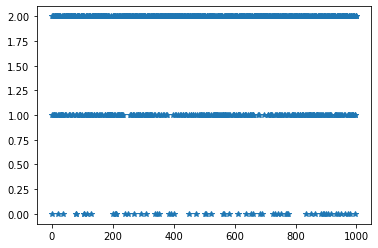

In [485]:
plt.plot(f_drop_out,"*")
f_drop_out_ratio = []
for ii,pt in enumerate(f_drop_out):
    if pt==2:
        f_drop_out_ratio.append(1)
    else:
        f_drop_out_ratio.append(0)
print (sum(f_drop_out_ratio)/len(f_drop_out_ratio))

0.944


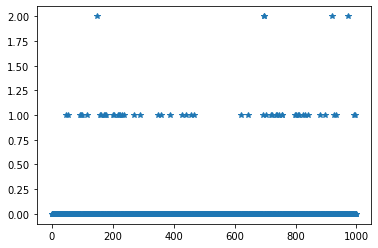

In [486]:
plt.plot(ground_drop_out,"*")
ground_drop_out_ratio = []
for ii,pt in enumerate(ground_drop_out):
    if pt==0:
        ground_drop_out_ratio.append(1)
    else:
        ground_drop_out_ratio.append(0)
print (sum(ground_drop_out_ratio)/len(ground_drop_out_ratio))

0.69


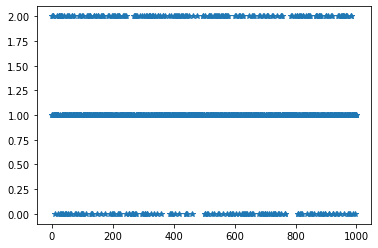

In [487]:
plt.plot(excited_drop_out,"*")
excited_drop_out_ratio = []
for ii,pt in enumerate(excited_drop_out):
    if pt==1:
        excited_drop_out_ratio.append(1)
    else:
        excited_drop_out_ratio.append(0)
print (sum(excited_drop_out_ratio)/len(excited_drop_out_ratio))

0.698


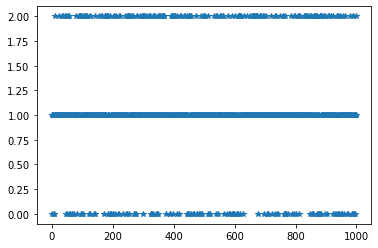

In [489]:
plt.plot(cycle_drop_out,"*")
cycle_drop_out_ratio = []
for ii,pt in enumerate(cycle_drop_out):
    if pt==1:
        cycle_drop_out_ratio.append(1)
    else:
        cycle_drop_out_ratio.append(0)
print (sum(cycle_drop_out_ratio)/len(cycle_drop_out_ratio))